#4 - Machine Learning
==================


Using sklearn, I explored various models in order to get the most accurate prediction model for my data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# --------linear-model
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from sklearn.model_selection import train_test_split
# --------cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# -------- classification
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
# *** KNN
from sklearn.neighbors import KNeighborsClassifier
# *** Decision Tree; Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# *** Naive Bayes
from sklearn.naive_bayes import GaussianNB
# *** SVM classifier
from sklearn.svm import SVC
# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer
# -------- Kmeans
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics, preprocessing, neighbors, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

`Preparing the data:`
-------------------------------------

Repeating the same process from the visualization chapter, I added new categorical columns and used feature engineering, dropping the string value columns and replacing them with new columns.

In [2]:
def load_data(filename):
    return pd.read_csv(filename)  #load file

In [3]:
def add_new_columns(df):
    #Remove the generated index column and convert the date column to datetime
    df.drop(columns=df.columns[0], axis=1, inplace=True) 
    df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
        
    #Create new columns based on the date
    df['day'] = df['date'].dt.day    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year    
    seasons = [(((df['month'] % 12 + 3) // 3) == 1),
               (((df['month'] % 12 + 3) // 3) == 2),
               (((df['month'] % 12 + 3) // 3) == 3),
               (((df['month'] % 12 + 3) // 3) == 4)]
    season_values = [1,2,3,4]
    df['season'] = np.select(seasons, season_values)
    
    #Create new columns based on the location
    regions = [(df['station'] == "Afula") | (df['station'] == "Karmiel"),
               (df['station'] == "Haifa") | (df['station'] == "Hadera"),
               (df['station'] == "Tel Aviv") | (df['station'] == "Rishon LeZion"),
               (df['station'] == "Ariel") | (df['station'] == "Jerusalem"),
               (df['station'] == "Ashdod") | (df['station'] == "Kiryat Gat") | (df['station'] == "Kfar Menachem"),
               (df['station'] == "Beer Sheva") | (df['station'] == "Arad")]
    region_values = [1,2,3,4,5,6]    #Galilee, Haifa, Center, Judea & Samaria, Shfela, Negev
    df['region'] = np.select(regions, region_values)
    
    terrain = [(df['station'] == "Haifa") | (df['station'] == "Jerusalem"),
               (df['station'] == "Ariel") | (df['station'] == "Kfar Menachem"),
               (df['station'] == "Afula") | (df['station'] == "Karmiel"),               
               (df['station'] == "Hadera") | (df['station'] == "Tel Aviv") | (df['station'] == "Rishon LeZion") | (df['station'] == "Ashdod") | (df['station'] == "Kiryat Gat"),
               (df['station'] == "Beer Sheva") | (df['station'] == "Arad")]
    terrain_values = [1,2,3,4,5] #Mountains, Hills, Valley, Plains, Desert
    df['terrain'] = np.select(terrain, terrain_values)
    df['station_code'] = df.station.astype("category").cat.codes
    
    #Create new column based on pollution        
    air_quality = [(df['NOX'] >= 0) & (df['NOX'] <= 50),
                   (df['NOX'] > 50) & (df['NOX'] <= 100),
                   (df['NOX'] > 100) & (df['NOX'] <= 150),
                   (df['NOX'] > 150)]
    air_quality_values = [1,2,3,4] #Good, Moderate, Low, Very low
    df['air_quality'] = np.select(air_quality, air_quality_values)
    
    #Create new column based on precipitation
    df['has_rained'] = np.where(df['precipitation']>0 , 1, 0)    
    rainfall_volumes = [(df['precipitation'] == 0),
                  (df['precipitation'] > 0) & (df['precipitation'] <= 5),
                  (df['precipitation'] > 5) & (df['precipitation'] <= 15),
                  (df['precipitation'] > 15)]    
    df['rainfall_volume'] = np.select(rainfall_volumes, season_values)
            
    return df

In [4]:
#Load the dataframe and expand it
df = load_data('data_final.csv')
df = add_new_columns(df)

#Drop string value columns
df_ml = df.drop(columns=['date', 'station'])
df_ml_no_outliers = df_ml.drop(df_ml[df_ml.precipitation > 65].index)
df_ml_no_outliers = df_ml_no_outliers.drop(df_ml_no_outliers[df_ml_no_outliers.NOX > 220].index)

In [5]:
df_ml

,NO,NO2,NOX,precipitation,day,month,year,season,region,terrain,station_code,air_quality,has_rained,rainfall_volume
0,1.5,3.8,6.1,13.6,1,1,2016,1,4,2,2,1,1,3
1,1.1,4.9,6.7,7.4,2,1,2016,1,4,2,2,1,1,3
2,1.4,10.8,13.0,9.0,3,1,2016,1,4,2,2,1,1,3
3,1.8,9.7,12.5,0.0,4,1,2016,1,4,2,2,1,0,1
4,2.1,11.8,15.1,0.0,5,1,2016,1,4,2,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23746,11.7,28.0,39.7,0.0,27,12,2020,1,3,4,12,1,0,1
23747,11.5,28.1,39.6,0.0,28,12,2020,1,3,4,12,1,0,1
23748,31.2,40.2,71.4,0.0,29,12,2020,1,3,4,12,2,0,1
23749,19.3,44.7,64.1,0.0,30,12,2020,1,3,4,12,2,0,1


`Supervised Learning:`
-------------------------------------

<h3>Regression</h3>

My data is not linear, and thus a linear regression model will not work.

Since my data includes a binary column (**has_rained**), I tested a logistic regression model, determining whether the day will be **rainy (1)** or **dry (0)**.

In [6]:
def train_predict_logistic_regression_model_date(df, day, month, class_weight):
    #Determine X and y
    X = df_ml[['day', 'month']]
    y = df_ml['has_rained'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)    
    
    #Train, predict and evaluate the performance   
    if (class_weight == "Balanced"):
        log_reg_model = linear_model.LogisticRegression(class_weight='balanced')
    else:
        log_reg_model = linear_model.LogisticRegression()
    log_reg_model.fit(X=X_train, y=y_train)    
    y_predicted = log_reg_model.predict(X_test)    
    res_predicted = log_reg_model.predict([[day, month]])[0]    
    if res_predicted == 0:
        result = "dry"
    else:
        result = "rainy"
    
    #Print the results and plot a matrix and graph    
    print("On the next {0}/{1} the day will be {2}.".format(day, month, result)) 
    print ("")
    print ("Classification report:")
    print ("----------------------")
    print(metrics.classification_report(y_test, y_predicted))
    print ("")
    print ("Confusion matrix:")
    print ("-----------------")
    conf_mat = confusion_matrix(y_test, y_predicted)       
    plt.figure(figsize=(5,5))
    sns.set(font_scale=1.5) 
    sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

On the next 13/2 the day will be dry.

Classification report:
----------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      5080
           1       0.00      0.00      0.00       858

    accuracy                           0.86      5938
   macro avg       0.43      0.50      0.46      5938
weighted avg       0.73      0.86      0.79      5938


Confusion matrix:
-----------------


D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


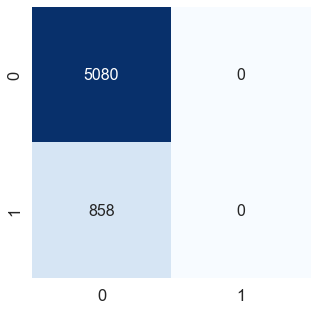

In [7]:
train_predict_logistic_regression_model_date(df_ml, 13, 2, 'None')

On the next 13/2 the day will be rainy.

Classification report:
----------------------
              precision    recall  f1-score   support

           0       0.91      0.58      0.71      5080
           1       0.21      0.66      0.32       858

    accuracy                           0.59      5938
   macro avg       0.56      0.62      0.51      5938
weighted avg       0.81      0.59      0.65      5938


Confusion matrix:
-----------------


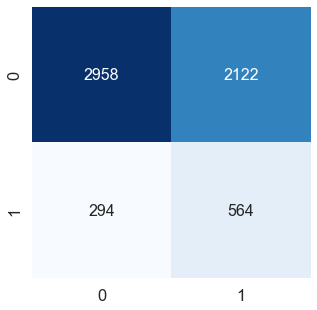

In [8]:
train_predict_logistic_regression_model_date(df_ml, 13, 2, 'Balanced')

<h3> Classification</h3>

I tested the four classification models we learned by comparing the scores and choosing the best model.

In [9]:
def get_classifier_obj(classifier_name, params):
        
    if classifier_name == 'KNN':
        if params== None: 
            clf = KNeighborsClassifier()
        else:
            clf = KNeighborsClassifier(**params)
    
    if classifier_name == 'naive_bayes':
        clf = GaussianNB()        
            
    if classifier_name == 'svm':
        clf = SVC()
    
    if classifier_name == 'decision_tree':
        if params == None:
            clf = DecisionTreeClassifier()            
        else:
            clf = DecisionTreeClassifier(**params)
    
    if classifier_name == 'random_forest':
        if params == None:
            clf = RandomForestClassifier()            
        else:
            clf = RandomForestClassifier(**params)    
   
    return clf

In [10]:
def find_best_model(X_train, y_train):
        
    clf_naive_bayes = get_classifier_obj("naive_bayes",None)
    clf_svm = get_classifier_obj("svm",None)
    clf_decision_tree_with_params = get_classifier_obj("decision_tree",None)    
      
    score_bayes = max(cross_val_score(clf_naive_bayes, X_train, y_train, scoring=make_scorer(accuracy_score), cv=10))
    score_svm = max(cross_val_score(clf_svm, X_train, y_train, scoring=make_scorer(accuracy_score), cv=10))
    score_dtree = max(cross_val_score(clf_decision_tree_with_params, X_train, y_train, scoring=make_scorer(accuracy_score), cv=10))
    max_score = max(score_bayes, score_svm, score_dtree)
    if max_score == score_bayes:
        best_clf = clf_naive_bayes
    if max_score == score_svm:
        best_clf = clf_svm
    if max_score == score_dtree:
        best_clf = clf_decision_tree_with_params  
    
    best_recall_val = max_score
    return best_clf, best_recall_val

In [11]:
X_clf = df_ml[['NO', 'NO2', 'NOX', 'region', 'terrain']]
y_clf = df_ml['has_rained']

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf)
best_clf, best_recall_val = find_best_model(X_clf_train, y_clf_train)
print(best_clf)
print(best_recall_val)

SVC()
0.8528916339135317


Classification report:
----------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      5106
           1       0.00      0.00      0.00       832

    accuracy                           0.86      5938
   macro avg       0.43      0.50      0.46      5938
weighted avg       0.74      0.86      0.80      5938


Confusion matrix:
-----------------


D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

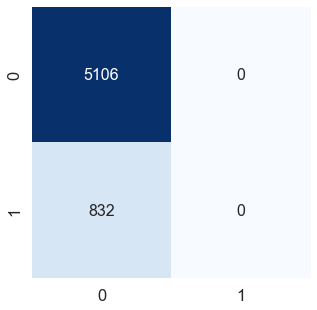

In [12]:
best_clf = best_clf.fit(X_clf_train, y_clf_train)
y_clf_predicted = best_clf.predict(X_clf_test)
print ("Classification report:")
print ("----------------------")
print(metrics.classification_report(y_clf_test, y_clf_predicted))
print ("")
print ("Confusion matrix:")
print ("-----------------")
conf_mat = confusion_matrix(y_clf_test, y_clf_predicted)       
plt.figure(figsize=(5,5))
sns.set(font_scale=1.5) 
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

`Unsupervised Learning:`
-------------------------------------

<h3> Kmeans clustering</h3>

Clustering only accepts numeric values, so I created a new dataframe which only takes the original data, except for the date columns.
    

In [13]:
df_clustering = df_ml[['NO', 'NO2', 'NOX', 'precipitation']]

In [14]:
def perform_k_means(dataset, num_clusters):
    model = KMeans(n_clusters = num_clusters)
    predicted_vals = model.fit_predict(dataset) 
    return model, predicted_vals

In [15]:
def get_best_num_of_clusters_for_k_means(dataset, num_cluster_options):
    
    #Initialize counters
    best_score_silhouette = 0
    best_score_elbow = 0    
    SSE = []
    sil_score = []
    
    #Determine the best scores and numbers of clusters
    for i in range(len(num_cluster_options)):
        model, predicted_vals = perform_k_means(dataset, num_cluster_options[i]) 
        
        score_silhouette = silhouette_score(dataset, predicted_vals)
        sil_score.append(score_silhouette)
        if (score_silhouette > best_score_silhouette):
            best_score_silhouette = score_silhouette
            num_clusters_silhouette = num_cluster_options[i]
            
        score_elbow = model.inertia_
        SSE.append(score_elbow)    
        if (score_elbow > best_score_elbow):
            best_score_elbow = score_elbow
            num_clusters_elbow = num_cluster_options[i]
        
    #Plot the figures
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8)) 
    fig.tight_layout(pad=3.5)
    
    frame_elbow = pd.DataFrame({'Cluster':num_cluster_options, 'SSE':SSE})    
    ax1.plot(frame_elbow['Cluster'], frame_elbow['SSE'], marker='o')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia')
    
    frame_sil = pd.DataFrame({'Cluster':num_cluster_options, 'sil_score':sil_score})    
    ax2.plot(frame_sil['Cluster'], frame_sil['sil_score'], marker='o')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Silhouette score')
    
    plt.show()
    return best_score_silhouette, num_clusters_silhouette, best_score_elbow, num_clusters_elbow

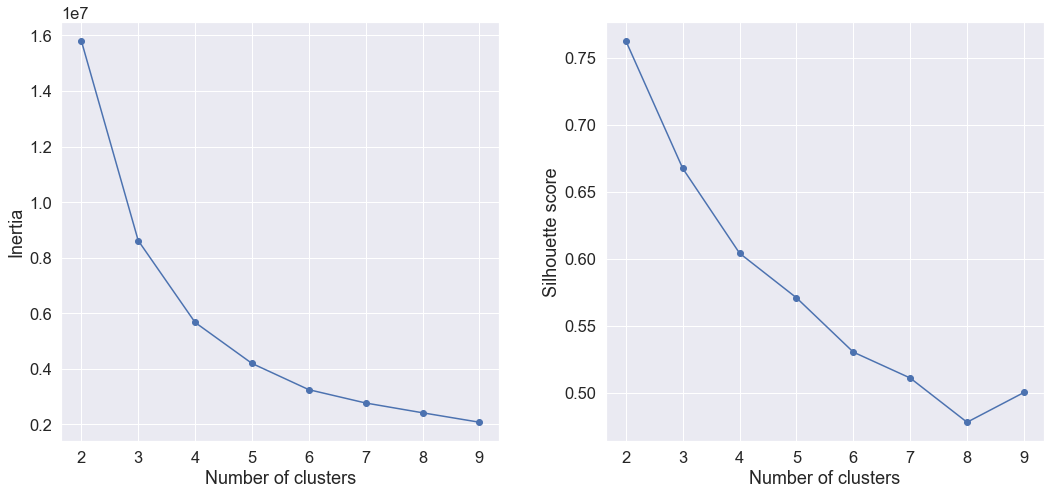

Best silhouette score: 0.7628094440600521
Best cluster number: 2
Best inertia score: 15805993.618638534
Best cluster number: 2


In [16]:
num_cluster_options = [2,3,4,5,6,7,8,9]
best_score_silhouette, num_clusters_silhouette, best_score_elbow, num_clusters_elbow = get_best_num_of_clusters_for_k_means(df_clustering, num_cluster_options)
print ("Best silhouette score:", best_score_silhouette)
print ("Best cluster number:", num_clusters_silhouette)

print ("Best inertia score:", best_score_elbow)
print ("Best cluster number:", num_clusters_elbow)

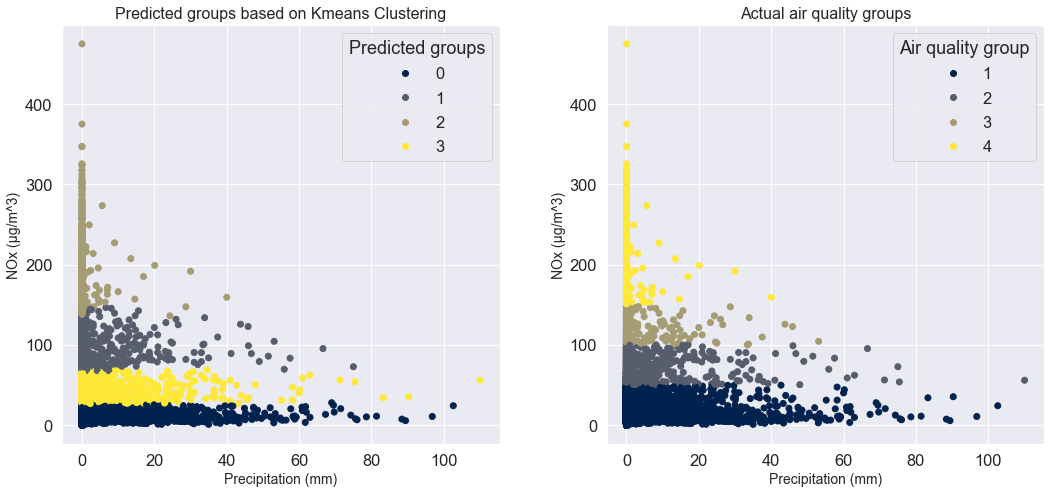

In [17]:
model, predicted_vals = perform_k_means(df_clustering, 4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8)) 
fig.tight_layout(pad=3.5)

sc1 = ax1.scatter(x=df_clustering['precipitation'], y=df_clustering['NOX'], c=predicted_vals, cmap='cividis')    
ax1.set_title("Predicted groups based on Kmeans Clustering", fontsize=16)    
ax1.set_xlabel("Precipitation (mm)", fontsize=14)
ax1.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc1.legend_elements()
ax1.legend(handles, labels, title="Predicted groups")
  
sc2 = ax2.scatter(x=df['precipitation'], y=df['NOX'], c=df['air_quality'], cmap='cividis')    
ax2.set_title("Actual air quality groups", fontsize=16)    
ax2.set_xlabel("Precipitation (mm)", fontsize=14)
ax2.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc2.legend_elements()
ax2.legend(handles, labels, title="Air quality group")

plt.show()

<h3> Hierarchical clustering & Density Based Clustering</h3>

Kmeans clustering gave a score of 0.763, but I wanted to see if the other model options can give a better score.

In [18]:
def perform_hierarchical_clustering(dataset, num_clusters, linkage_val):
    model = AgglomerativeClustering(n_clusters = num_clusters, linkage = linkage_val).fit(dataset)
    predicted_vals = model.fit_predict(dataset)
    
    #Plot the figure
    #fig, ax = plt.figure(figsize=(16, 8))        
    #frame_elbow = pd.DataFrame({'Cluster':num_cluster_options, 'SSE':SSE})    
    #ax.plot(frame_elbow['Cluster'], frame_elbow['SSE'], marker='o')
    #ax.set_xlabel('Number of clusters')
    #ax.set_ylabel('Inertia')
    
    return model, predicted_vals

In [19]:
def get_best_linkage_method(dataset, num_clusters, linkage_options):    
    best_score = 0
    for i in range(len(linkage_options)):
        model, predicted_vals = perform_hierarchical_clustering(dataset, num_clusters, linkage_options[i]) 
        score = silhouette_score(dataset, predicted_vals)  
        if (score > best_score):
            best_score = score
            best_linkage = linkage_options[i]
    return best_score, best_linkage

In [20]:
linkage_options = ['single', 'complete', 'average', 'ward']
num_clusters = 4
best_score, best_linkage = get_best_linkage_method(df_clustering, 4, linkage_options)
print("Best score:", best_score)
print("Best linkage:", best_linkage)

Best score: 0.8093161270208279
Best linkage: average


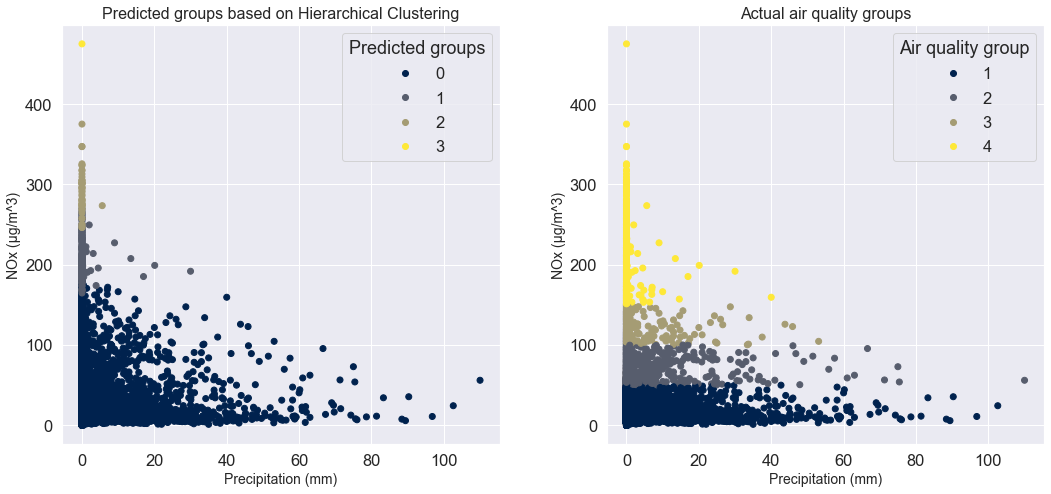

In [21]:
hierarchical_model, hierarchical_pred = perform_hierarchical_clustering(df_clustering, 4, 'average')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8)) 
fig.tight_layout(pad=3.5)

sc1 = ax1.scatter(x=df_clustering['precipitation'], y=df_clustering['NOX'], c=hierarchical_pred, cmap='cividis')    
ax1.set_title("Predicted groups based on Hierarchical Clustering", fontsize=16)    
ax1.set_xlabel("Precipitation (mm)", fontsize=14)
ax1.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc1.legend_elements()
ax1.legend(handles, labels, title="Predicted groups")
  
sc2 = ax2.scatter(x=df['precipitation'], y=df['NOX'], c=df['air_quality'], cmap='cividis')    
ax2.set_title("Actual air quality groups", fontsize=16)    
ax2.set_xlabel("Precipitation (mm)", fontsize=14)
ax2.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc2.legend_elements()
ax2.legend(handles, labels, title="Air quality group")

plt.show()

In [22]:
def perform_density_based_clustering(dataset, epsilon_val, minimum_samples_val):
    model = DBSCAN(eps = epsilon_val, min_samples = minimum_samples_val).fit(dataset)
    predicted_vals = model.fit_predict(dataset) 
    return model, predicted_vals

In [23]:
def get_best_params_for_dbscan(dataset, eps_options, min_samples_options):
    best_score = 0
    for i in range(len(eps_options)):
        for j in range(len(min_samples_options)):
            model, predicted_vals = perform_density_based_clustering(dataset, eps_options[i], min_samples_options[j]) 
            score = silhouette_score(dataset, predicted_vals)  
            if (score > best_score):
                best_score = score
                best_eps = eps_options[i]
                best_min_samples = min_samples_options[j]
    
    
    return best_score, best_eps, best_min_samples

In [24]:
eps_options = [10,11,12]
min_samples_options = [4,5,6,7,8]

best_score, best_eps, best_min_samples = get_best_params_for_dbscan(df_clustering, eps_options, min_samples_options)
print("Best score:", best_score)
print("Best epsilon:", best_eps)
print("Best min samples:", best_min_samples)

Best score: 0.8106130071863359
Best epsilon: 12
Best min samples: 7


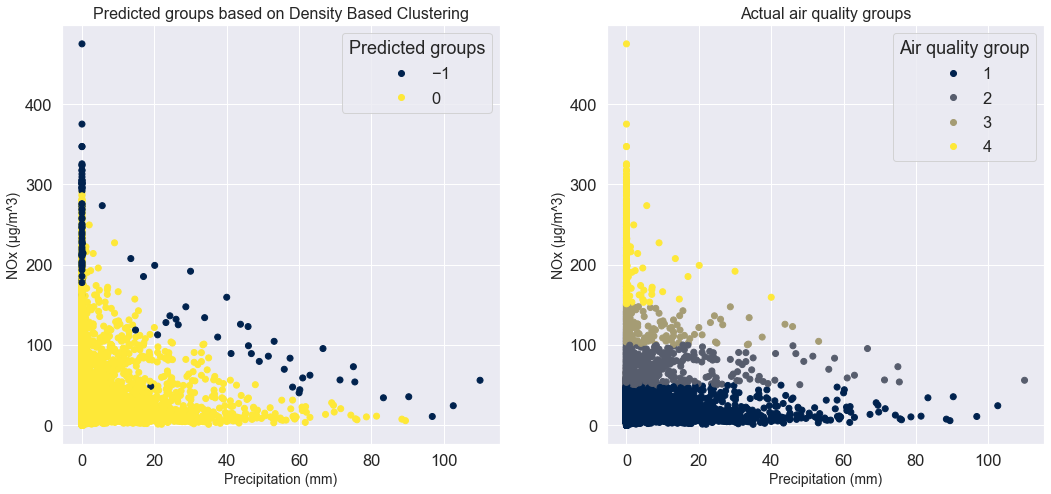

In [25]:
dbs_model, dbs_pred = perform_density_based_clustering(df_clustering, 12, 7)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 8)) 
fig.tight_layout(pad=3.5)

sc1 = ax1.scatter(x=df_clustering['precipitation'], y=df_clustering['NOX'], c=dbs_pred, cmap='cividis')    
ax1.set_title("Predicted groups based on Density Based Clustering", fontsize=16)    
ax1.set_xlabel("Precipitation (mm)", fontsize=14)
ax1.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc1.legend_elements()
ax1.legend(handles, labels, title="Predicted groups")
  
sc2 = ax2.scatter(x=df['precipitation'], y=df['NOX'], c=df['air_quality'], cmap='cividis')    
ax2.set_title("Actual air quality groups", fontsize=16)    
ax2.set_xlabel("Precipitation (mm)", fontsize=14)
ax2.set_ylabel("NOx (μg/m^3)", fontsize=14)
handles, labels = sc2.legend_elements()
ax2.legend(handles, labels, title="Air quality group")

plt.show()